#### This notebook holds a machine learning model that predicts which genre a user will listen to based on the time of day
**Models**: random forest or logistical regression <br>
**Features**: hour, day_of_week, is_weekend, season <br>
**Target**: genre/artist (prefrebly artists) <br>
**Desired Output**: "Its 9pm on a friday, You will probably listen to X"

In [47]:
from spotipy import Spotify
from spotipy.oauth2 import SpotifyOAuth
from collections import Counter
import requests
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from dotenv import load_dotenv
load_dotenv()

from spotifyAnalysis import recently_played_tracks

### Authetication

In [48]:
def get_spotify_client():
    auth_manager = SpotifyOAuth(
        client_id = os.getenv("SPOTIPY_CLIENT_ID"),
        client_secret = os.getenv("SPOTIPY_CLIENT_SECRET"),
        redirect_uri = os.getenv("SPOTIPY_REDIRECT_URI"),
        scope = "user-read-private user-top-read user-read-recently-played"
    )
    sp = Spotify(auth_manager=auth_manager)
    return sp, sp.auth_manager.get_access_token(as_dict=False)

sp, token = get_spotify_client()
print("Connected to Spotify api")

Connected to Spotify api


## Data Collection
- ~~track name, artist, genre~~
- ~~played_at~~
    - ~~hour, day_of_week, is_weekend~~

run this a few times a day to get the data

In [49]:
from genres import manual_genre_map
def generate_df(sp, limit=50, csv_path="listening_habits.csv"):
    data = []
    tracks = recently_played_tracks(sp, limit=limit)
    for track in tracks:
        name = track['name']
        artist = track['artists']
        played_at = track['played_at']
        genre = track['genre']

        timestamp = pd.to_datetime(played_at)
        hour = timestamp.hour
        day_of_week = timestamp.dayofweek
        is_weekend = 1 if day_of_week >=5 else 0

        data.append({
            'name': name,
            'artist': artist,
            'genre': genre,
            'played_at': played_at,
            'hour': hour,
            'day_of_week': day_of_week,
            'is_weekend': is_weekend,
            'is_workday': 1 - is_weekend
        })

    df = pd.DataFrame(data)
    df['time_of_day'] = pd.cut(df['hour'],
                            bins=[-1, 6, 12, 18, 24],
                            labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    # df = df.drop_duplicates(subset=['name', 'artist'])
    df['played_at'] = pd.to_datetime(df['played_at'])

    # load csv into function
    if os.path.exists(csv_path):
        existing_df = pd.read_csv(csv_path, parse_dates=['played_at'])
        combined_df = pd.concat([existing_df, df], ignore_index=True)
        combined_df.drop_duplicates(subset=['name', 'artist', 'played_at'], inplace=True)
    else:
        combined_df = df

    # fill in missing genres
    genre_cache = {} 
    for idx, row in combined_df[combined_df['genre'] == 'Unknown'].iterrows():
        artist = row['artist']
        if artist not in genre_cache:
            genre_cache[artist] = get_artist_genre(sp, artist)
        combined_df.at[idx, 'genre'] = genre_cache[artist]
    
    combined_df.to_csv(csv_path, index=False)
    
    return combined_df

def get_artist_genre(sp, artist_name):
    results = sp.search(q=f'artist: {artist_name}', type='artist', limit=1)
    if results['artists']['items']:
        artist = results['artists']['items'][0]
        genres = artist['genres']
        return genres[0] if genres else 'Unknown'
    return "Unknown"

generate_df(sp, limit=50)


,name,artist,genre,played_at,hour,day_of_week,is_weekend,is_workday,time_of_day
0,Fading Out,Pentire,Unknown,2025-11-17 18:20:46.537000+00:00,18,0,0,1,Afternoon
1,I Don't Mind,M60,bassline,2025-11-17 18:11:12.435000+00:00,18,0,0,1,Afternoon
2,Motorcycle Boy,Fontaines D.C.,post-punk,2025-11-17 18:07:33.253000+00:00,18,0,0,1,Afternoon
3,Bug,Fontaines D.C.,post-punk,2025-11-17 18:03:51.074000+00:00,18,0,0,1,Afternoon
4,Death Kink,Fontaines D.C.,post-punk,2025-11-17 18:01:02.525000+00:00,18,0,0,1,Afternoon
...,...,...,...,...,...,...,...,...,...
206,Penseiri,Breichiau Hir,classical,2025-11-20 12:41:22.371000+00:00,12,3,0,1,Morning
207,Swigen o Genfigen,Y Cledrau,bassline,2025-11-20 12:37:03.529000+00:00,12,3,0,1,Morning
208,Haf 2013,Fleur De Lys,Unknown,2025-11-20 12:33:50.499000+00:00,12,3,0,1,Morning
209,Pen Y Byd,Bwncath,Unknown,2025-11-20 12:30:46.312000+00:00,12,3,0,1,Morning


#### Giving 'unknown' genres a genre using manual mapping

In [50]:
from genres import manual_genre_map, genre_groups

# giving each entrie a genre
df = pd.read_csv("listening_habits.csv")
df['genre'] = df['artist'].map(manual_genre_map).fillna(df['genre'])

# grouing the genres
df['genre'] = df['genre'].map(genre_groups).fillna('other')
df.to_csv("listening_habits_genre_mapped.csv", index=False)



## Training Model

#### Prepare data

In [51]:
df = pd.read_csv("listening_habits_genre_mapped.csv")
# drop the unknown genres for now
df = df[df['genre'] != 'Unknown']

features = ['hour', 'day_of_week', 'is_weekend', 'is_workday'] # , 'time_of_day', 'artist'
X = df[features]
y = df['genre']
print(y.value_counts())

genre
indie_rock    129
welsh          49
other          12
pop            11
electronic      6
retro           3
folk            1
Name: count, dtype: int64


#### Test Train Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 168
Testing samples: 43


#### Train on multiple different models

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
models = {
    'logistic regression' : LogisticRegression(max_iter=1000),
    'random forest' : RandomForestClassifier(n_estimators=100, random_state=42),
    'decision tree classifier' : DecisionTreeClassifier(random_state=42),
    'knn' : KNeighborsClassifier(n_neighbors=5),
    'NB' : GaussianNB()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    results[name] = score
    print(f"{name}: {score:.2%} accuracy")

best_model = max(results, key=results.get)
print(f"Best performing model is: {best_model}")


logistic regression: 83.72% accuracy
random forest: 79.07% accuracy
decision tree classifier: 79.07% accuracy
knn: 81.40% accuracy
NB: 79.07% accuracy
Best performing model is: logistic regression


#### Evaluation

Classifivation Report
              precision    recall  f1-score   support

  electronic       0.20      0.50      0.29         2
        folk       0.00      1.00      0.00         0
  indie_rock       0.94      0.58      0.71        26
       other       0.00      0.00      0.00         1
         pop       0.00      0.00      0.00         2
       retro       0.00      1.00      0.00         0
       welsh       0.89      0.67      0.76        12

    accuracy                           0.56        43
   macro avg       0.29      0.53      0.25        43
weighted avg       0.82      0.56      0.66        43



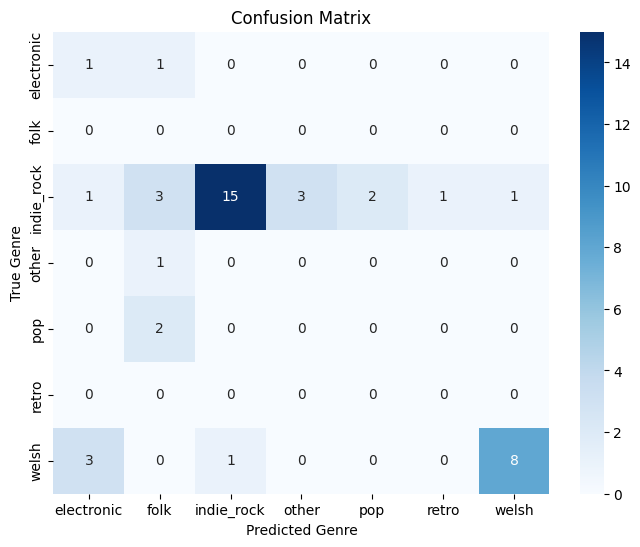

In [55]:
model = LogisticRegression(max_iter=1000, class_weight='balanced') # Use best model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Classifivation Report\n{classification_report(y_test, y_pred, zero_division=1)}")

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Genre')
plt.xlabel('Predicted Genre')
plt.show()

#### Hyperparameter Tuning

In [56]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2%}")

best_model = grid_search.best_estimator_

c:\Users\willi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation score: 80.96%


In [ ]:
import datetime
def predict_genre(hour, day_of_week, is_weekend, is_workday):
    input_data = pd.DataFrame({
        'hour': [hour],
        'day_of_week': [day_of_week],
        'is_weekend': [is_weekend],
        'is_workday': [is_workday]
    })

    prediction = model.predict(input_data)[0]
    probabilities = model.predict_proba(input_data)[0]
    
    print(f"Predicted genre: {prediction}")
    print("\nProbabilities:")
    for genre, prob in zip(model.classes_, probabilities):
        print(f"  {genre}: {prob:.1%}")
    
    return prediction

now = datetime.datetime.now()
hour = now.hour
day_of_week = now.weekday()
is_weekend = int(day_of_week >= 5)
is_workday = int(day_of_week < 5)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#print(predict_genre(hour=15, day_of_week=1, is_weekend=0, is_workday=1))

print(f"\nHey, its currently {hour}:00 on a {days[day_of_week]}. You should probably listen to some {predict_genre(hour=hour, day_of_week=day_of_week, is_weekend=is_weekend, is_workday=is_workday)} music")



Predicted genre: indie_rock

Probabilities:
  electronic: 10.1%
  folk: 0.0%
  indie_rock: 26.7%
  other: 26.3%
  pop: 16.8%
  retro: 4.4%
  welsh: 15.7%
indie_rock
Predicted genre: welsh

Probabilities:
  electronic: 24.7%
  folk: 0.0%
  indie_rock: 3.6%
  other: 17.8%
  pop: 10.5%
  retro: 0.2%
  welsh: 43.1%

Hey, its currently 13:00 on a Thursday. You should probably listen to some welsh music
